In [1]:
import scanpy as sc
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
import itertools as it

In [2]:
FILE = "datasets/10XGenomics/Targeted_SC3v3_Human_Glioblastoma_Neuroscience_filtered_feature_bc_matrix.h5"

In [3]:
adata = sc.read_10x_h5(FILE)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
X = adata.X.todense()
np.count_nonzero(X)

1850701

In [6]:
X.shape

(5697, 1186)

In [6]:
def cell(i):
    return np.array(X[i, :]).flatten()

In [18]:
ncells = X.shape[0]
sims = np.zeros((ncells, ncells))

cells = []
for i in tqdm.trange(ncells):
    cells.append(cell(i))

for i in tqdm.trange(ncells):
    for j in range(ncells):
        a, b = cells[i], cells[j]
        sims[i][j] = sum((a == b) & (a != 0))

100%|███████████████████████████████████████| 5697/5697 [26:13<00:00,  3.62it/s]


In [20]:
sims2 = np.zeros((ncells, ncells))

for i in tqdm.trange(ncells):
    for j in range(ncells):
        a, b = cells[i], cells[j]
        sims2[i][j] = np.count_nonzero(cells[i]) - sims[i][j]

100%|██████████████████████████████████████| 5697/5697 [00:50<00:00, 113.51it/s]


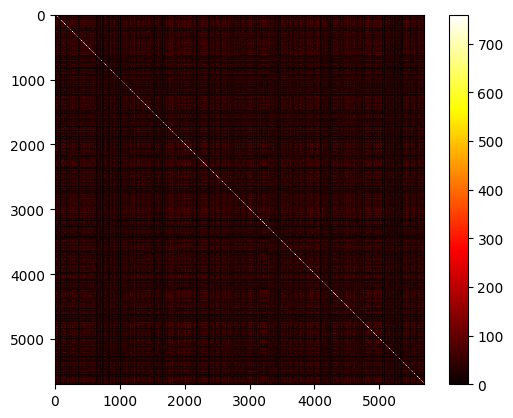

In [81]:
plt.imshow(sims, cmap='hot', interpolation='none')
plt.colorbar()


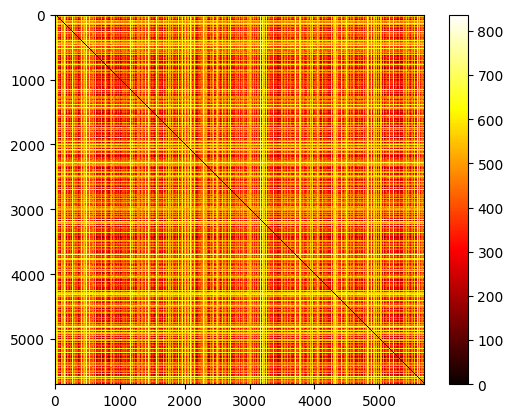

In [9]:
plt.imshow(sims, cmap='hot', interpolation='none')
plt.colorbar()

In [86]:
[i for i, j in enumerate(cells) if np.count_nonzero(j) == 760][0]

4399

In [87]:
i = 4399
x = np.quantile(list(sims[i][:i]) + list(sims[i][i + 1:]), 0.9)
L = cells[i].shape[0]
out = np.full(L, True)
out &= cells[i] != 0

s_arr = list(zip(range(L), sims[i]))

for k, v in sorted(s_arr, key = lambda i: -i[1]):
    if k == i or v < x:
        continue

    # print(k, v)
    out &= cells[i] == cells[k]
    print(sum(out))

103
19
4
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [69]:
sorted(s_arr, key = lambda i: -i[1])

[(14, 234.0),
 (595, 47.0),
 (459, 46.0),
 (69, 45.0),
 (290, 43.0),
 (605, 43.0),
 (686, 43.0),
 (788, 43.0),
 (344, 42.0),
 (502, 42.0),
 (503, 42.0),
 (690, 42.0),
 (722, 42.0),
 (762, 42.0),
 (814, 42.0),
 (236, 41.0),
 (271, 41.0),
 (3, 40.0),
 (309, 40.0),
 (472, 40.0),
 (770, 40.0),
 (876, 40.0),
 (976, 40.0),
 (1015, 40.0),
 (175, 39.0),
 (328, 39.0),
 (489, 39.0),
 (506, 39.0),
 (526, 39.0),
 (543, 39.0),
 (577, 39.0),
 (677, 39.0),
 (713, 39.0),
 (733, 39.0),
 (755, 39.0),
 (807, 39.0),
 (830, 39.0),
 (859, 39.0),
 (998, 39.0),
 (1021, 39.0),
 (1076, 39.0),
 (1084, 39.0),
 (1155, 39.0),
 (1170, 39.0),
 (97, 38.0),
 (232, 38.0),
 (356, 38.0),
 (370, 38.0),
 (390, 38.0),
 (487, 38.0),
 (709, 38.0),
 (919, 38.0),
 (960, 38.0),
 (1011, 38.0),
 (1012, 38.0),
 (1029, 38.0),
 (154, 37.0),
 (240, 37.0),
 (272, 37.0),
 (353, 37.0),
 (363, 37.0),
 (364, 37.0),
 (385, 37.0),
 (423, 37.0),
 (432, 37.0),
 (587, 37.0),
 (635, 37.0),
 (850, 37.0),
 (941, 37.0),
 (980, 37.0),
 (981, 37.0),
 

In [11]:
sims2 = np.zeros((ncells, ncells))

for i in tqdm.trange(ncells):
    for j in range(ncells):
        sims2[i][j] = np.count_nonzero(cells[i] - cells[j])

100%|███████████████████████████████████████| 5697/5697 [01:40<00:00, 56.89it/s]


In [51]:
max(cells[2])

597.0

In [83]:
sims2[3000][1958]

526.0

In [87]:
np.count_nonzero(cells[3000] - cells[1958])

526

In [88]:
np.count_nonzero(cells[3000]), np.count_nonzero(cells[1958])

(443, 316)

In [107]:
def similarity(cell1, cell2):
    return nonzeros[cell1] - sims2[cell1][cell2]

def best_friend(cell):
    return max(it.chain(range(cell), range(cell + 1, ncells)), key=lambda other: similarity(cell, other))

def max_similarity(cell):
    return max(map(lambda other: similarity(cell, other), it.chain(range(cell), range(cell + 1, ncells))))

In [111]:
sims2[0][560]

84.0

In [123]:
max_similarity(1053)

-12.0

In [122]:
best_friend(1053)

4617

{'whiskers': [<matplotlib.lines.Line2D at 0x2c80ad880>,
 'caps': [<matplotlib.lines.Line2D at 0x2ca458890>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c7fb4f80>],
 'medians': [<matplotlib.lines.Line2D at 0x2ca458fe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ca459a30>],
 'means': []}

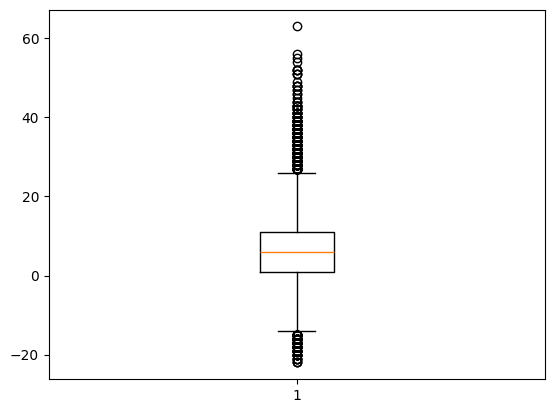

In [108]:
bests = [max_similarity(i) for i in range(ncells)]
plt.boxplot(bests)

In [137]:
# best_cells = [best_friend(i) for i in range(ncells)]
representatives = []
for i in tqdm.trange(ncells):
    if max_similarity(i) > 0:
        representatives.append(i)
sum(Counter(representatives).values())

100%|██████████████████████████████████████| 5697/5697 [00:07<00:00, 795.01it/s]


4337

In [143]:
best_friend(4933)

1710

In [141]:
best_friend(2)

4933

In [146]:
nonzeros[2], nonzeros[4933]

(438, 83)

In [145]:
sims2[4933][2]

428.0

In [139]:
c

Counter({2: 1,
         3: 1,
         4: 1,
         5: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         13: 1,
         14: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         23: 1,
         26: 1,
         27: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         61: 1,
         64: 1,
         66: 1,
         67: 1,
         68: 1,
         69: 1,
         70: 1,
         72: 1,
         73: 1,
         74: 1,
         75: 1,
         76: 1,
         77: 1,
         78: 1,
         79: 1,
         80: 1,
         81: 1,
         83: 1

In [147]:
c = Counter(representatives)
sum(v for v in c.values())# if v != 1)

4337

In [89]:
nonzeros = zeros[:]
bests = []
best_cells = []
for i in tqdm.trange(ncells):
    best_difference = None
    best_cell_difference = None
    for j in range(i + 1, ncells):
        sim = sims2[i][j] # np.count_nonzero(cells[i] - cells[j])
        difference = nonzeros[i] - sim
        if not best_difference or difference > best_difference:
            best_difference = difference
            best_cell_difference = j
    if best_difference:
        bests.append(best_difference)
        best_cells.append(best_cell_difference)

100%|█████████████████████████████████████| 5697/5697 [00:04<00:00, 1225.60it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x31519eb40>,
 'caps': [<matplotlib.lines.Line2D at 0x31519e3f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ca3ec2c0>],
 'medians': [<matplotlib.lines.Line2D at 0x31519d4f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x31519fce0>],
 'means': []}

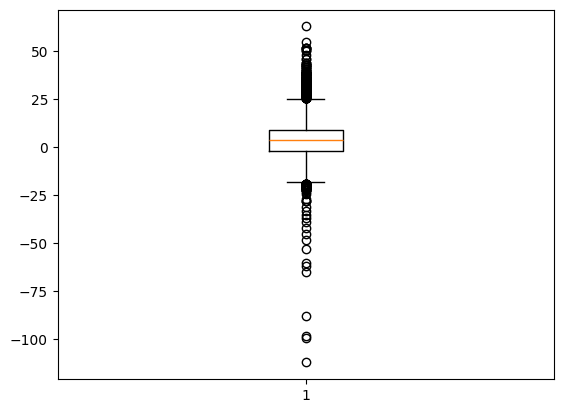

In [90]:
plt.boxplot(bests)

In [91]:
Counter(best_cells)

Counter({5602: 455,
         5681: 169,
         5359: 142,
         5543: 111,
         5128: 102,
         4602: 91,
         4504: 90,
         5510: 71,
         5244: 65,
         4322: 64,
         3325: 59,
         4953: 58,
         5372: 58,
         3593: 57,
         4512: 56,
         4617: 54,
         4476: 51,
         5035: 48,
         4695: 46,
         5614: 42,
         5281: 42,
         3336: 41,
         4675: 41,
         4017: 39,
         3491: 39,
         5346: 38,
         1458: 37,
         5154: 35,
         5220: 35,
         4933: 33,
         3437: 32,
         1053: 31,
         4863: 30,
         5419: 30,
         5473: 28,
         5568: 28,
         2244: 25,
         3663: 25,
         2167: 24,
         1606: 24,
         4250: 24,
         4140: 24,
         5429: 24,
         2285: 23,
         5179: 22,
         5227: 22,
         3384: 21,
         5273: 21,
         4157: 20,
         5075: 20,
         1525: 20,
         5319: 20,
       

In [62]:
np.quantile(diffs, 0.9999)

59.012800000001334

In [41]:
sum(zeros)

1850701

In [48]:
109976.0 / ncells

19.304195190451114

In [45]:
696379 / 1850701

0.37627850203787644

In [31]:
sims2[0]

array([  0., 134., 443., ..., 237., 473., 292.])

In [35]:
np.count_nonzero(cells[1])

85

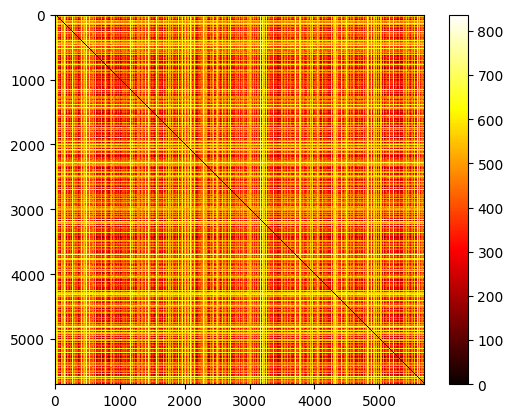

In [10]:
plt.imshow(sims2, cmap='hot', interpolation='none')
plt.colorbar()

{'whiskers': [<matplotlib.lines.Line2D at 0x2bde7fc80>,
 'caps': [<matplotlib.lines.Line2D at 0x2cb5d7a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cb5d7260>],
 'medians': [<matplotlib.lines.Line2D at 0x2cb5d7f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cb66c290>],
 'means': []}

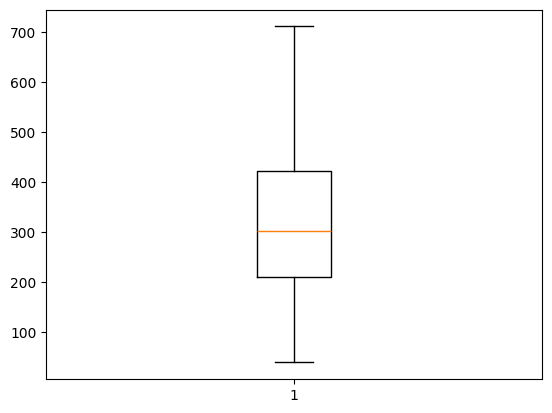

In [11]:
x = [min([i for i in j if i != 0]) for j in sims2]
plt.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x2cb680f20>,
 'caps': [<matplotlib.lines.Line2D at 0x2cb6e28d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cb6e22a0>],
 'medians': [<matplotlib.lines.Line2D at 0x2cb6e2ea0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cb6e3170>],
 'means': []}

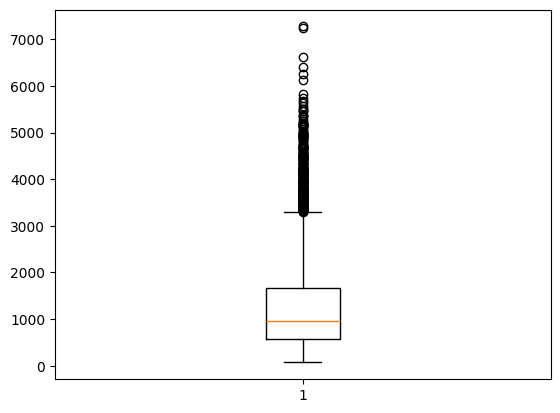

In [12]:
x = [min([i for i in j if i != 0]) for j in sims]
plt.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x315584bf0>,
 'caps': [<matplotlib.lines.Line2D at 0x3155853d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3155875f0>],
 'medians': [<matplotlib.lines.Line2D at 0x315585040>],
 'fliers': [<matplotlib.lines.Line2D at 0x3155861e0>],
 'means': []}

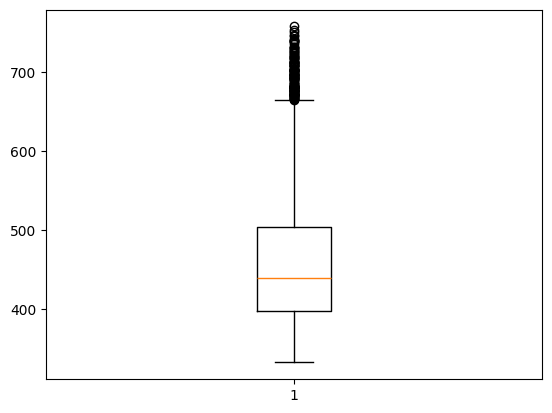

In [52]:
x = [np.average([i for i in j if i != 0]) for j in sims2]
plt.boxplot(x)

310.0


{'whiskers': [<matplotlib.lines.Line2D at 0x31595eab0>,
 'caps': [<matplotlib.lines.Line2D at 0x3159ac2c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x31595fbc0>],
 'medians': [<matplotlib.lines.Line2D at 0x3159ac7a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x3159aca70>],
 'means': []}

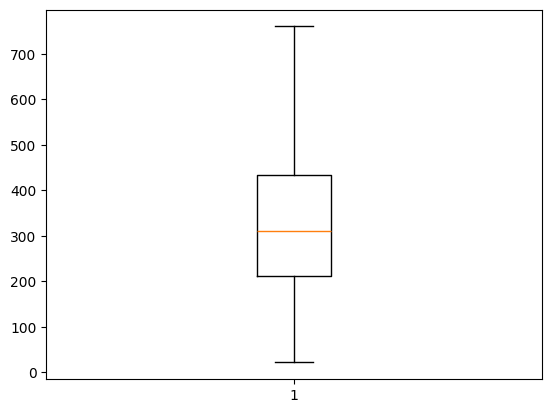

In [25]:
x = [np.count_nonzero(i) for i in cells]
print(np.quantile(x, 0.50))
plt.boxplot(x)

4262113

In [30]:
from math import sqrt
sqrt(4262113)

2064.4885565195077

In [24]:
x = [np.average([i for i in j if i != 0]) for j in sims2]
max_avg_sim = np.quantile(x, 0.75)

In [15]:
good_cells = []
weird_cells = []
for i, c in enumerate(cells):
    if x[i] < max_avg_sim:
        good_cells.append(c)
    else:
        weird_cells.append(c)

In [16]:
len(good_cells)

4272

In [54]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=19).fit(np.array(good_cells))

In [55]:
representatives = []
for cluster in range(n_clusters):
    best_member = None
    best_distance = None
    for i, cell in enumerate(good_cells):
        if kmeans.labels_[i] == cluster:
            dist = sum(abs(a - b) for a, b in zip(cell, kmeans.cluster_centers_[cluster]))
            if not best_distance or dist < best_distance:
                best_member = i
                best_distance = dist
    representatives.append((best_member, best_distance))
    # print(cluster, best_member, best_distance)

In [56]:
clustered = []
for i, cell in enumerate(good_cells):
    cluster = kmeans.labels_[i]
    representative = good_cells[representatives[cluster][0]]
    if i != representatives[cluster][0]:
        clustered.append([int(a - b) for a, b in zip(cell, representative)])

In [57]:
Counter(np.array(clustered).flatten())

Counter({0: 3669258,
         1: 398996,
         -1: 368396,
         2: 140184,
         -2: 118275,
         3: 63909,
         -3: 50802,
         4: 34891,
         -4: 29529,
         5: 21715,
         6: 14812,
         -5: 14701,
         7: 10723,
         -6: 10591,
         -7: 9947,
         8: 8190,
         9: 6517,
         -8: 6218,
         10: 5141,
         11: 4197,
         -12: 3955,
         12: 3641,
         -9: 3337,
         13: 3035,
         -10: 2908,
         -11: 2733,
         14: 2611,
         15: 2351,
         16: 1987,
         17: 1791,
         -13: 1700,
         -15: 1640,
         18: 1541,
         19: 1386,
         -14: 1279,
         20: 1219,
         21: 1167,
         -16: 1070,
         22: 1054,
         23: 974,
         24: 932,
         25: 879,
         26: 768,
         27: 710,
         -17: 705,
         28: 675,
         -18: 603,
         29: 596,
         30: 588,
         31: 556,
         32: 495,
         -19: 470,
     

In [58]:
Counter(kmeans.labels_)

Counter({6: 1965, 7: 670, 4: 529, 1: 475, 0: 279, 3: 198, 2: 132, 5: 24})

In [21]:
for i, cell in enumerate(good_cells):
    cluster = kmeans.cluster_centers_[kmeans.labels_[i]]
    k = [int(a - b) for a, b in zip(cell, cluster)]
    print(Counter(k))

Counter({0: 1051, -1: 64, -2: 26, -4: 9, -6: 7, -3: 7, 1: 6, -7: 4, -8: 3, 2: 2, -12: 2, -5: 2, -9: 2, -16: 1})
Counter({0: 1047, -1: 62, -2: 23, -3: 12, 1: 10, -5: 8, -6: 6, -4: 4, -8: 3, -12: 2, -7: 2, 5: 2, 33: 1, 16: 1, 2: 1, -15: 1, -10: 1})
Counter({0: 922, 1: 74, 2: 42, -1: 41, 3: 16, 4: 15, -3: 10, -2: 9, 5: 6, -7: 4, 15: 3, 7: 3, -5: 3, -4: 3, -6: 3, 8: 3, -17: 2, -12: 2, 13: 2, -15: 1, -9: 1, 89: 1, 9: 1, -14: 1, 16: 1, 12: 1, 30: 1, 67: 1, 6: 1, 21: 1, 20: 1, 496: 1, 42: 1, -18: 1, 14: 1, -13: 1, 32: 1, 139: 1, 39: 1, -139: 1, 27: 1, 11: 1})
Counter({0: 1020, 1: 54, -1: 35, 2: 27, -2: 8, 3: 8, 4: 6, 6: 4, 5: 3, -3: 3, -4: 2, -7: 2, 14: 1, -33: 1, 21: 1, 7: 1, -9: 1, -45: 1, 45: 1, 12: 1, 60: 1, -17: 1, 18: 1, 8: 1, 56: 1, -6: 1})
Counter({0: 1018, 1: 47, -1: 35, 2: 18, 3: 13, -2: 13, 5: 6, 4: 5, -4: 3, 7: 3, -3: 3, 20: 2, -6: 2, -16: 2, 6: 2, 9: 2, -37: 1, -20: 1, -10: 1, 55: 1, 25: 1, -8: 1, 12: 1, -28: 1, 8: 1, -5: 1, 28: 1, 13: 1})
Counter({0: 1036, 1: 43, -1: 31, 2: 19, 

In [22]:
c = Counter(np.array(cells).flatten())

In [23]:
del c[0]
[c[j] for j in range(1, 483)]

[742869,
 332837,
 183193,
 114213,
 77401,
 55838,
 42245,
 33373,
 27063,
 21912,
 18233,
 15907,
 13561,
 11765,
 10384,
 9064,
 8155,
 7358,
 6762,
 6103,
 5595,
 5033,
 4681,
 4379,
 3995,
 3794,
 3497,
 3241,
 3118,
 2922,
 2608,
 2517,
 2238,
 2142,
 2072,
 1941,
 1909,
 1748,
 1658,
 1619,
 1460,
 1424,
 1442,
 1262,
 1219,
 1234,
 1131,
 1051,
 1009,
 1004,
 1022,
 877,
 875,
 882,
 856,
 852,
 794,
 718,
 736,
 709,
 652,
 622,
 623,
 543,
 574,
 528,
 547,
 529,
 543,
 485,
 481,
 458,
 449,
 431,
 417,
 427,
 390,
 392,
 389,
 382,
 365,
 365,
 360,
 337,
 311,
 319,
 285,
 298,
 296,
 271,
 284,
 256,
 268,
 263,
 281,
 252,
 246,
 253,
 236,
 245,
 205,
 222,
 223,
 228,
 185,
 188,
 186,
 174,
 200,
 190,
 166,
 171,
 169,
 193,
 166,
 164,
 152,
 174,
 148,
 161,
 146,
 167,
 153,
 148,
 142,
 123,
 149,
 138,
 121,
 143,
 132,
 123,
 101,
 120,
 105,
 111,
 120,
 107,
 103,
 118,
 90,
 113,
 106,
 106,
 105,
 99,
 118,
 94,
 89,
 75,
 84,
 88,
 77,
 85,
 86,
 95,
 80,


In [24]:
[(j, c[j]) for j in range(483, 2551) if j in c]

[(484, 2),
 (485, 2),
 (486, 3),
 (487, 4),
 (489, 3),
 (490, 4),
 (492, 3),
 (493, 1),
 (494, 3),
 (495, 4),
 (496, 4),
 (497, 4),
 (498, 2),
 (499, 3),
 (500, 3),
 (501, 4),
 (502, 3),
 (503, 6),
 (504, 1),
 (505, 4),
 (506, 2),
 (507, 3),
 (509, 5),
 (510, 1),
 (511, 5),
 (512, 1),
 (513, 3),
 (515, 2),
 (516, 5),
 (517, 4),
 (518, 4),
 (519, 3),
 (520, 4),
 (521, 2),
 (522, 6),
 (523, 5),
 (524, 3),
 (525, 2),
 (526, 5),
 (527, 2),
 (528, 3),
 (529, 7),
 (530, 1),
 (531, 4),
 (532, 2),
 (533, 5),
 (535, 3),
 (536, 2),
 (538, 7),
 (539, 4),
 (540, 3),
 (541, 3),
 (542, 5),
 (543, 2),
 (544, 3),
 (546, 6),
 (547, 2),
 (548, 8),
 (549, 4),
 (550, 2),
 (551, 1),
 (552, 1),
 (553, 1),
 (554, 3),
 (555, 2),
 (557, 3),
 (558, 3),
 (559, 4),
 (560, 1),
 (561, 4),
 (562, 2),
 (563, 4),
 (564, 1),
 (565, 1),
 (566, 2),
 (567, 4),
 (568, 1),
 (569, 2),
 (570, 1),
 (571, 1),
 (572, 2),
 (573, 5),
 (574, 3),
 (575, 3),
 (576, 4),
 (577, 1),
 (578, 2),
 (579, 2),
 (580, 4),
 (581, 1),
 (582, 1),

In [25]:
sum(c.values())

1850701

In [26]:
max(c)

2551.0

In [27]:
(5697 * 1186)

6756642

In [28]:
B = lambda i: len(bin(i)) - 2
N = sum(c.values())
O = c[1]

i = 1
while i in c:
    i += 1
K = i - 1

T1 = 0
T2 = []
M = int(max(c))
for j in range(i, M):
    if j not in c:
        continue
    T1 += 1
    T2.append(c[j])

T = T1
S = max(T2)

N * B(N) + K * B(O) + T * (B(M) + B(S))

38881689